In [1]:
import torch
import triton
import triton.language as tl
from transformers.models.llama.modeling_llama import LlamaRMSNorm
from copy import deepcopy
from core.rmsnorm import TritonRMSNorm

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- 进一步优化，将add和norm的操作进行融合
- 比单独优化norm，又提速大概30%

# Core

In [2]:
@triton.jit
def _add_rmsnorm_fwd(X, OLD_RESIDUAL, W, NEW_RESIDUAL, Y, RMS_STD, eps,
                 stride_n, stride_d,
                 BLOCK_N:tl.constexpr,
                 N: tl.constexpr):
    start_n = tl.program_id(0)
    offset = start_n * stride_n
    cols = tl.arange(0, BLOCK_N)
    mask = cols < N
    x_ptrs = X + offset + cols
    y_ptrs = Y + offset + cols
    w_ptrs = W + cols
    old_residual_ptrs = OLD_RESIDUAL + offset + cols
    new_residual_ptrs  = NEW_RESIDUAL + offset + cols

    x = tl.load(x_ptrs, mask=mask, other=0.).to(tl.float32)
    old_residual = tl.load(old_residual_ptrs, mask=mask, other=0.).to(tl.float32)
    new_residual = x + old_residual
    tl.store(new_residual_ptrs, new_residual, mask=mask)
    
    w = tl.load(w_ptrs, mask=mask, other=0.)

    rms_std = tl.sqrt(tl.sum(new_residual * new_residual) / N + eps)
    new_residual_hat = new_residual / rms_std
    y = new_residual_hat.to(w.dtype) * w

    tl.store(y_ptrs, y, mask=mask)
    tl.store(RMS_STD+start_n, rms_std)

@triton.jit
def _add_rmsnorm_bwd_dx_fused(DX, DOLD_RES, DNEW_RES, DY, DW, NEW_RES, W, RMS_STD, Lock,
                 stride_n, stride_d,
                 BLOCK_N:tl.constexpr, GROUP_SIZE: tl.constexpr, 
                 N: tl.constexpr):
    start_n = tl.program_id(0)
    lock_id = start_n % GROUP_SIZE
    Lock += lock_id
    Count = Lock + GROUP_SIZE
    offset = start_n * stride_n
    cols = tl.arange(0, BLOCK_N)
    mask = cols < N
    # x_ptrs = X + offset + cols
    w_ptrs = W + cols
    dx_ptrs = DX + offset + cols
    dy_ptrs = DY + offset + cols
    dw_ptrs = DW + lock_id * N + cols
    dold_res_ptrs = DOLD_RES + offset + cols
    dnew_res_ptrs = DNEW_RES + offset + cols
    # old_res_ptrs = OLD_RES + offset + cols
    new_res_ptrs = NEW_RES + offset + cols

    new_res = tl.load(new_res_ptrs, mask=mask, other=0.).to(tl.float32)
    w = tl.load(w_ptrs, mask=mask, other=0.).to(tl.float32)
    dy = tl.load(dy_ptrs, mask=mask, other=0.).to(tl.float32)
    rms_std = tl.load(RMS_STD+start_n)

    new_res_hat = new_res / rms_std
    wdy = w * dy
    dnew_res = (wdy - (new_res_hat / N) * tl.sum(new_res_hat * wdy)) / rms_std
    dnew_res += tl.load(dnew_res_ptrs, mask=mask, other=0.).to(tl.float32)
    tl.store(dx_ptrs, dnew_res, mask=mask)
    tl.store(dold_res_ptrs, dnew_res, mask=mask)

    partial_dw = new_res_hat * dy
    while tl.atomic_cas(Lock, 0, 1) == 1:
        pass
    count = tl.load(Count)
    # First store doesn't accumulate
    if count == 0:
        tl.atomic_xchg(Count, 1)
    else:
        partial_dw += tl.load(dw_ptrs, mask=mask, other=0.)
    tl.store(dw_ptrs, partial_dw, mask=mask)
    tl.atomic_xchg(Lock, 0)

@triton.jit
def _add_rmsnorm_bwd_dw(PART_DW, DW,
                 stride_m, stride_d,
                 BLOCK_NN:tl.constexpr, GROUP_SIZE: tl.constexpr, 
                 N: tl.constexpr):
    group_id = tl.program_id(0)
    offset_nn = group_id*BLOCK_NN

    partial_dw_ptrs = tl.make_block_ptr(
        base=PART_DW,
        shape=(GROUP_SIZE, N),
        strides=(stride_m, stride_d),
        offsets=(0, offset_nn),
        block_shape=(GROUP_SIZE, BLOCK_NN),
        order=(1,0),
    )
    
    partial_dw = tl.load(partial_dw_ptrs, boundary_check=(1,), padding_option='zero').to(tl.float32)
    dw = tl.sum(partial_dw, 0)
    tl.store(DW + offset_nn + tl.arange(0, BLOCK_NN), dw, mask=(offset_nn+tl.arange(0, BLOCK_NN)) < N)

class _TritronFusedAddRMSNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, hidden_state, old_residual, weight, eps):
        input_shape = hidden_state.shape
        output = torch.empty_like(hidden_state)
        new_residual = torch.empty_like(hidden_state)
        hidden_state = hidden_state.reshape(-1, input_shape[-1])
        M,N = hidden_state.shape
        BLOCK_N = triton.next_power_of_2(N)
        rms_std = torch.empty(M, dtype=torch.float32, device=hidden_state.device)
        
        num_warps=8
        num_stages=1
        _add_rmsnorm_fwd[(M, )](hidden_state, old_residual, weight, new_residual, output, rms_std, eps,
                            *hidden_state.stride(),
                            BLOCK_N,
                            N,
                            num_warps=num_warps, num_stages=num_stages)
        ctx.save_for_backward(hidden_state, new_residual, weight, rms_std)
        ctx.input_shape = input_shape
        ctx.BLOCK_N = BLOCK_N
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return output, new_residual
    
    @staticmethod
    def backward(ctx, dy, dnew_res):
        # dy = dy.contiguous()
        # dnew_res = dnew_res.contiguous()
        # print(dy.stride(), dnew_res.stride())
        hidden_state, new_residual, weight, rms_std = ctx.saved_tensors
        M,N = hidden_state.shape
        input_shape = ctx.input_shape
        N = input_shape[-1]
        GROUP_SIZE = 64
        if N <= 8192: GROUP_SIZE = 64
        if N <= 4096: GROUP_SIZE = 128
        if N <= 1024: GROUP_SIZE = 256
        # GROUP_SIZE = min(1024, triton.next_power_of_2(M))
        BLOCK_NN = min(128, triton.next_power_of_2(N))

        dw = torch.empty_like(weight)
        dx = torch.empty_like(dy)
        dold_residual = torch.empty_like(dy)

        partial_dw = torch.zeros((GROUP_SIZE, input_shape[-1]), device=weight.device, dtype=weight.dtype)
        lock = torch.zeros(GROUP_SIZE*2, device=weight.device, dtype=torch.int32)
        # DX, DOLD_RES, DNEW_RES, DY, DW, NEW_RES, W, RMS_STD, Lock,
        _add_rmsnorm_bwd_dx_fused[(M,)](dx, dold_residual, dnew_res, dy, partial_dw, new_residual, weight, rms_std, lock,
                 *hidden_state.stride(),
                 ctx.BLOCK_N, GROUP_SIZE, 
                 N,
                 num_warps=ctx.num_warps, num_stages=ctx.num_stages)
        grid = lambda meta: (triton.cdiv(N, BLOCK_NN), )
        _add_rmsnorm_bwd_dw[grid](partial_dw, dw,
                 *partial_dw.stride(),
                 BLOCK_NN, GROUP_SIZE, 
                 N,
                 num_warps=ctx.num_warps, num_stages=ctx.num_stages)
        return dx, dold_residual, dw, None

triton_fused_add_norm = _TritronFusedAddRMSNorm.apply
class TritonFusedAddRMSNorm(torch.nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.ones(hidden_size))
        self.eps = eps
    
    def forward(self, hidden_state, old_residual):
        return triton_fused_add_norm(hidden_state, old_residual, self.weight, self.eps)

class TritonAddRMSNorm(torch.nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.norm = TritonRMSNorm(hidden_size, eps)
    
    def forward(self, hidden_state, old_residual):
        new_residual = hidden_state + old_residual
        output = self.norm(new_residual)
        return output, new_residual
    
class LlamaAddRMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.norm = LlamaRMSNorm(hidden_size=dim, eps=eps)

    def forward(self, hidden_state, old_residual):
        new_residual = hidden_state + old_residual
        output = self.norm(new_residual)
        return output, new_residual

# 精度测试

In [12]:
# bf16的grad误差有点大
dtype = torch.float32
device = 'cuda'
rtol = 1e-8
atol = 1e-4
dim = 8
x1 = torch.randn(4, dim).to(device).to(dtype)
res1 = torch.randn(4, dim).to(device).to(dtype)
x1.requires_grad_(True)
res1.requires_grad_(True)
x2 = deepcopy(x1)
res2 = deepcopy(res1)
fused_add_norm = TritonFusedAddRMSNorm(dim).to(device).to(dtype)
llama_add_norm = LlamaAddRMSNorm(dim).to(device).to(dtype)
fused_add_norm.weight.data.copy_(llama_add_norm.norm.weight.data)
y1, new_res1 = fused_add_norm(x1,res1)
y2, new_res2 = llama_add_norm(x2,res2)
print(torch.allclose(y1,y2, rtol=rtol, atol=atol))
print(torch.allclose(new_res1,new_res2, rtol=rtol, atol=atol))
k = torch.rand_like(x1).T # 乘上结果，防止dy，dres的stride都为0

True
True


In [13]:
if x1.grad is not None:
    x1.grad.zero_()
    res1.grad.zero_()
loss = (y1 + new_res1) @ k
loss.sum().backward(retain_graph=True)

if x2.grad is not None:
    x2.grad.zero_()
    res2.grad.zero_()
loss = (y2 + new_res2) @ k
loss.sum().backward(retain_graph=True)

print(torch.allclose(x1.grad, x2.grad, rtol=rtol, atol=atol))
print(torch.allclose(res1.grad, res2.grad, rtol=rtol, atol=atol))
print(torch.allclose(fused_add_norm.weight.grad, llama_add_norm.norm.weight.grad, rtol=rtol, atol=atol))

True
True
True


# forward

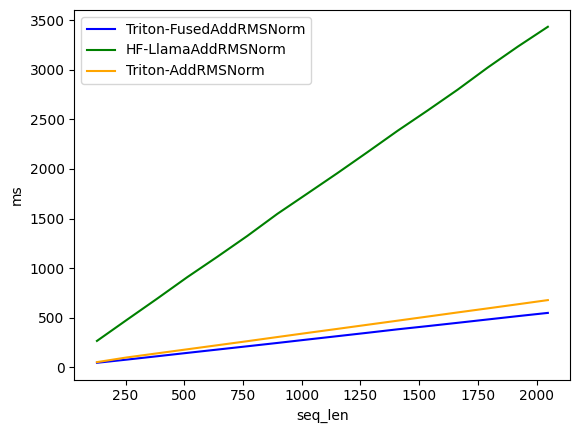

RMSNorm:
    seq_len  Triton-FusedAddRMSNorm  HF-LlamaAddRMSNorm  Triton-AddRMSNorm
0     128.0               45.710843          266.034544          52.289128
1     256.0               77.953361          479.695022          99.841498
2     384.0              111.410357          691.520274         140.639544
3     512.0              145.254463          907.866716         181.433126
4     640.0              178.658411         1113.278031         222.269937
5     768.0              211.994976         1323.882818         263.222933
6     896.0              245.581791         1546.602249         305.115342
7    1024.0              280.032933         1751.637101         346.708238
8    1152.0              314.008653         1957.639933         387.535334
9    1280.0              348.167121         2169.169188         428.907990
10   1408.0              383.047640         2384.047508         470.124274
11   1536.0              415.392190         2588.916540         511.595666
12   1664.0     

In [7]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedAddRMSNorm', 'HF-LlamaAddRMSNorm', 'Triton-AddRMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedAddRMSNorm",
            "HF-LlamaAddRMSNorm",
            "Triton-AddRMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="RMSNorm",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 3584, 'bs': 16}

    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    res = torch.randn_like(x)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'HF-LlamaAddRMSNorm':
        func = LlamaAddRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: func(x, res))
    if provider == 'Triton-FusedAddRMSNorm':
        func = TritonFusedAddRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: func(x, res))
    if provider == 'Triton-AddRMSNorm':
        func = TritonAddRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: func(x, res))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


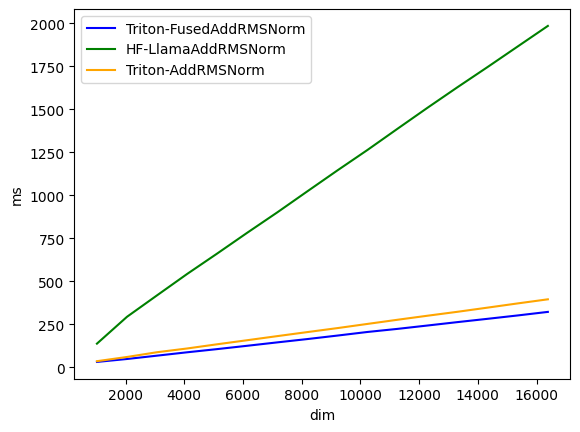

RMSNorm:
        dim  Triton-FusedAddRMSNorm  HF-LlamaAddRMSNorm  Triton-AddRMSNorm
0    1024.0               31.710621          138.045847          35.974726
1    2048.0               48.747953          294.148326          60.499687
2    3072.0               68.196461          418.942600          88.117898
3    4096.0               87.716311          543.123066         109.881751
4    5120.0              106.250919          661.918521         134.328648
5    6144.0              125.632167          782.863259         157.950401
6    7168.0              145.355403          901.360810         181.738034
7    8192.0              164.657921         1023.736954         205.208376
8    9216.0              184.917554         1145.316839         228.349313
9   10240.0              205.888644         1264.269948         252.686918
10  11264.0              223.854020         1387.601256         276.900887
11  12288.0              243.461847         1509.976625         300.419778
12  13312.0     

In [16]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedAddRMSNorm', 'HF-LlamaAddRMSNorm', 'Triton-AddRMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedAddRMSNorm",
            "HF-LlamaAddRMSNorm",
            "Triton-AddRMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="RMSNorm",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 4}

    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    res = torch.randn_like(x)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'HF-LlamaAddRMSNorm':
        func = LlamaAddRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: func(x, res))
    if provider == 'Triton-FusedAddRMSNorm':
        func = TritonFusedAddRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: func(x, res))
    if provider == 'Triton-AddRMSNorm':
        func = TritonAddRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: func(x, res))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


# backward

bs: 8, seq_len: 1024


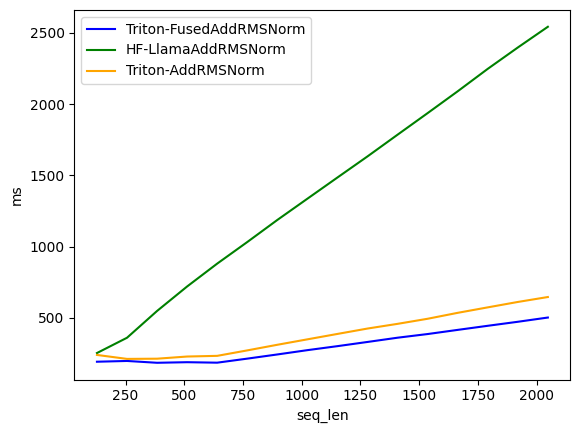

RMSNorm:
    seq_len  Triton-FusedAddRMSNorm  HF-LlamaAddRMSNorm  Triton-AddRMSNorm
0     128.0              191.466376          252.427757         239.099860
1     256.0              196.827993          359.723687         211.279824
2     384.0              184.037894          547.802269         212.717444
3     512.0              188.113719          719.688952         227.917343
4     640.0              184.778765          880.068481         232.668281
5     768.0              213.142991         1031.508327         270.947516
6     896.0              242.430732         1186.484694         310.395986
7    1024.0              272.667140         1335.644007         348.534703
8    1152.0              300.763249         1484.498262         386.514902
9    1280.0              330.199301         1632.653236         424.311280
10   1408.0              360.058218         1784.955978         457.288295
11   1536.0              385.740548         1936.439991         492.984265
12   1664.0     

In [3]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedAddRMSNorm', 'HF-LlamaAddRMSNorm', 'Triton-AddRMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedAddRMSNorm",
            "HF-LlamaAddRMSNorm",
            "Triton-AddRMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="RMSNorm",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4096, 'bs': 4}

    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    res = torch.randn_like(x)
    x.requires_grad_(True)
    res.requires_grad_(True)
    k = torch.randn(dim, bs).to(device).to(dtype) # 乘上结果，防止dy，dres的stride都为0
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def cal_loss(func, x, res, k):
        m,n = func(x, res)
        y = m * n
        return y.sum()

    if provider == 'HF-LlamaAddRMSNorm':
        func = LlamaAddRMSNorm(dim).cuda().to(dtype)
        loss = cal_loss(func, x, res, k)
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[x, res])
    if provider == 'Triton-FusedAddRMSNorm':
        func = TritonFusedAddRMSNorm(dim).cuda().to(dtype)
        loss = cal_loss(func, x, res, k)
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[x, res])
    if provider == 'Triton-AddRMSNorm':
        func = TritonAddRMSNorm(dim).cuda().to(dtype)
        loss = cal_loss(func, x, res, k)
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[x, res])

    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


bs: 8, seq_len: 1024


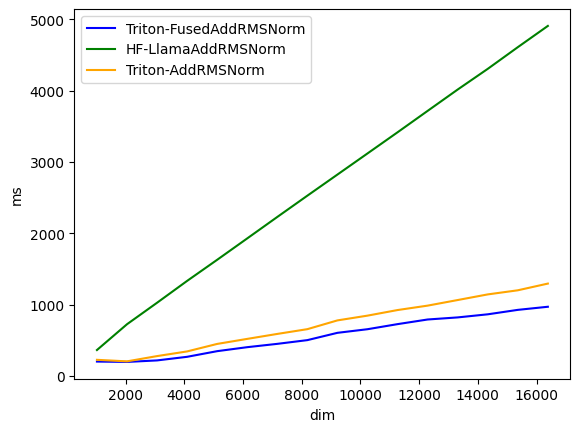

RMSNorm:
        dim  Triton-FusedAddRMSNorm  HF-LlamaAddRMSNorm  Triton-AddRMSNorm
0    1024.0              203.983754          365.659446         228.291467
1    2048.0              198.899835          727.126360         206.737339
2    3072.0              219.983920         1028.235435         280.638039
3    4096.0              270.588607         1334.504008         346.062094
4    5120.0              349.703997         1630.307078         451.170921
5    6144.0              405.576736         1930.040836         521.750450
6    7168.0              452.097952         2230.541706         591.282904
7    8192.0              504.346907         2528.745174         657.997906
8    9216.0              606.610537         2824.479103         780.764997
9   10240.0              657.239497         3120.333195         847.524285
10  11264.0              728.436947         3416.821003         925.850511
11  12288.0              793.402135         3716.742516         987.731814
12  13312.0     

In [4]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedAddRMSNorm', 'HF-LlamaAddRMSNorm', 'Triton-AddRMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedAddRMSNorm",
            "HF-LlamaAddRMSNorm",
            "Triton-AddRMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="RMSNorm",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 4}

    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    res = torch.randn_like(x)
    x.requires_grad_(True)
    res.requires_grad_(True)
    k = torch.randn(dim, bs).to(device).to(dtype) # 乘上结果，防止dy，dres的stride都为0
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def cal_loss(func, x, res, k):
        m,n = func(x, res)
        y = m * n
        return y.sum()

    if provider == 'HF-LlamaAddRMSNorm':
        func = LlamaAddRMSNorm(dim).cuda().to(dtype)
        loss = cal_loss(func, x, res, k)
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[x, res])
    if provider == 'Triton-FusedAddRMSNorm':
        func = TritonFusedAddRMSNorm(dim).cuda().to(dtype)
        loss = cal_loss(func, x, res, k)
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[x, res])
    if provider == 'Triton-AddRMSNorm':
        func = TritonAddRMSNorm(dim).cuda().to(dtype)
        loss = cal_loss(func, x, res, k)
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[x, res])

    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# forward + backward

bs: 8, seq_len: 1024


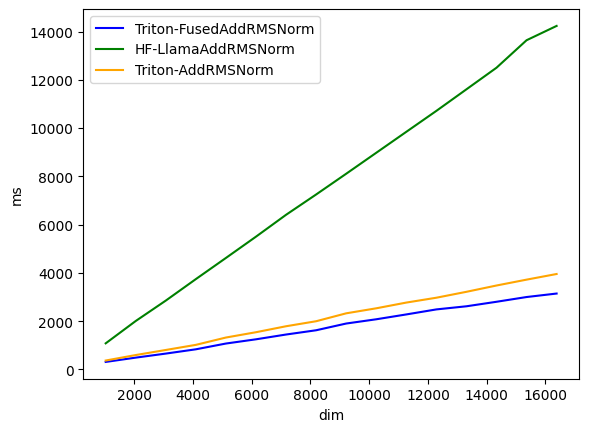

RMSNorm:
        dim  Triton-FusedAddRMSNorm  HF-LlamaAddRMSNorm  Triton-AddRMSNorm
0    1024.0              312.786788         1082.774282         370.698899
1    2048.0              490.781963         2009.328127         598.080754
2    3072.0              658.320963         2854.454041         808.081985
3    4096.0              835.531592         3745.017290        1019.921303
4    5120.0             1074.729681         4620.774269        1323.258758
5    6144.0             1249.752164         5502.821445        1543.424606
6    7168.0             1447.869420         6408.534527        1790.728569
7    8192.0             1624.331951         7249.459267        1998.551369
8    9216.0             1903.211594         8108.747482        2326.001406
9   10240.0             2079.409361         8977.203369        2534.174919
10  11264.0             2280.172110         9845.845222        2771.609545
11  12288.0             2488.277435        10713.479996        2972.722530
12  13312.0     

In [5]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedAddRMSNorm', 'HF-LlamaAddRMSNorm', 'Triton-AddRMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedAddRMSNorm",
            "HF-LlamaAddRMSNorm",
            "Triton-AddRMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="RMSNorm",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8}

    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    res = torch.randn_like(x)
    x.requires_grad_(True)
    res.requires_grad_(True)
    k = torch.randn(dim, 2).to(device).to(dtype) # 乘上结果，防止dy，dres的stride都为0
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def for_and_back(func, x, res, k):
        m,n = func(x, res)
        y = m * n
        loss = y.sum()
        loss.backward(retain_graph=True)

    if provider == 'HF-LlamaAddRMSNorm':
        func = LlamaAddRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: for_and_back(func, x, res, k), grad_to_none=[x, res])
    if provider == 'Triton-FusedAddRMSNorm':
        func = TritonFusedAddRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: for_and_back(func, x, res, k), grad_to_none=[x, res])
    if provider == 'Triton-AddRMSNorm':
        func = TritonAddRMSNorm(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: for_and_back(func, x, res, k), grad_to_none=[x, res])

    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
